# Demo for Bedrock Agent calling Comfyui API

* Scenario:   
Based on your inputs, Bedrock will extract image description then enrich and rewrite it into a Stable Diffusion prompt. After that, it will automatically call Comfyui by leveraging Bedrock Agent to generate an image for you  

> User inputs can be any language, but eventually, a generated prompt for Stable Diffusion will be English

> The best input for creating images is providing image description directly, if you provide irrelevant, Claude will ask you for more inputs, it may cause some confusions, such as prompt not always English, prompt is not enriched, still needs more PE

> A standard "ml.t3.medium" SageMaker notebook instance is sufficient to run the demo（excluding Comfyui env.）  


### Pre-requests:
The content didn't cover Comfyui installation.

* Assumed you alreay have an installed Comfyui env. 

> Regarding how to [install Comfyui](https://github.com/comfyanonymous/ComfyUI?tab=readme-ov-file#installing)

* Record your public endpoint of Comfyui, we will use it later  

> e.g. in my case: "ec2-34-204-96-192.compute-1.amazonaws.com:8080", no need with "http://"  


* Enable Comfyui "Dev mode Options", and record(save) "API format" of the workdlow which you want to use, we will use it later  

> More details about Comfyui API and Dev mode, check [this thread](https://github.com/comfyanonymous/ComfyUI/issues/930)    

> In my case, I use standard sdxl workflow for Comfyui API

### 1. Evn. Initialization

In [1]:
!pip install boto3 awscli -Uq

In [2]:
import boto3
import json
import os
import uuid
import requests
from IPython.display import display, Image

boto3_session = boto3.session.Session()

### 2. Creat S3 bucket

In [3]:
suffix = uuid.uuid4().hex[:4]
bucket_name = f'bedrock-agent-schemas-{suffix}'

s3_client = boto3_session.client('s3')
s3_client.create_bucket(Bucket=bucket_name)

print("S3 bucket is: ", bucket_name)

S3 bucket is:  bedrock-agent-schemas-6ab4


### 3. Prepare action group OpenAPI schemas of Bedrock Agent and upload to S3

In [4]:
%%writefile ./ActionSchema.json
{
  "openapi": "3.0.1",
  "info": {
    "title": "ImageCreatorAssistant API",
    "description": "API for creating image",
    "version": "1.0.0"
  },
  "paths": {
    "/createImage": {
      "post": {
        "description": "Create an image by specifying description",
        "parameters": [
          {
            "name": "description",
            "in": "query",
            "description": "Description of image",
            "required": true,
            "schema": {
              "type": "string"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "Successful response with URLs and descriptions of created images",
            "content": {
              "application/json": {
                "schema": {
                  "type": "string",
                  "description": "Return URLs and descriptions of created images"
                }
              }
            }
          }
        }
      }
    }
  }
}

Overwriting ./ActionSchema.json


In [5]:
s3_client.upload_file('./ActionSchema.json', bucket_name, 'ActionSchema/ActionSchema.json')

### 4. Create Lambda function for Bedrock Agent

Prepare Lambda function codes

In [6]:
%%writefile ./lambda_function.py
import os
import json
import random
from urllib import request, parse

server_address = os.environ['server_address']
prompt_text = os.environ['prompt_text']

def lambda_handler(event, context):
    print(event)
    
    api_path = event['apiPath']
    image_description = next((parameter['value'] for parameter in event['parameters'] if parameter['name'] == 'description'), None)
    print(image_description)
  
    def queue_prompt(prompt):
        p = {"prompt": prompt}
        data = json.dumps(p).encode('utf-8')
        req =  request.Request("http://{}/prompt".format(server_address), data=data)
        # request.urlopen(req)
        return json.loads(request.urlopen(req).read())
      
    def get_history(prompt_id):
        while True:
          with request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
            data = json.loads(response.read())
            if data:
              return data
        
    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = parse.urlencode(data)
        image_url = "http://{}/view?{}".format(server_address, url_values)

        return image_url
      
    prompt = json.loads(prompt_text)
    
    #set the text prompt for our positive and negtive CLIPTextEncode
    prompt["6"]["inputs"]["text"] = prompt["15"]["inputs"]["text"] = image_description
    negative_prompt = "ugly, disfigured, distorted body, bad anatomy, bad hands, text, watermark"
    prompt["7"]["inputs"]["text"] = prompt["16"]["inputs"]["text"] = negative_prompt
    
    #set the seed for our KSampler node
    random_integer = random.randint(1, 18446744073709551615)
    prompt["10"]["inputs"]["noise_seed"] = random_integer
    
    if api_path == '/createImage':
        resp = queue_prompt(prompt)
        prompt_id = resp['prompt_id']
    
        history = get_history(prompt_id)[prompt_id]
    
        output_images = {}
        for node_id in history['outputs']:
          node_output = history['outputs'][node_id]
          if 'images' in node_output:
            images_output = []
            for image in node_output['images']:
              image_data = get_image(image['filename'], image['subfolder'], image['type'])
              images_output.append(image_data)
          output_images[image_description] = images_output
    else:
        response_code = 404
        output_images = f"Unrecognized api path: {action_group}::{api_path}"
    
    response_body = {
        'application/json': {
            'body': output_images
        }
    }
    
    action_response = {
        'actionGroup': event['actionGroup'],
        'apiPath': event['apiPath'],
        'httpMethod': event['httpMethod'],
        'httpStatusCode': 200,
        'responseBody': response_body
    }
    
    session_attributes = event['sessionAttributes']
    prompt_session_attributes = event['promptSessionAttributes']
    
    api_response = {
        'messageVersion': '1.0', 
        'response': action_response,
        'sessionAttributes': session_attributes,
        'promptSessionAttributes': prompt_session_attributes
    }
    
    print(api_response)
    
    return api_response

Writing ./lambda_function.py


In [7]:
# Create Lambda role with default policy

iam_client = boto3_session.client('iam')

role_name = f'bedrock-agent-lambdaRole-{suffix}'
response = iam_client.create_role(
    RoleName=role_name,
    AssumeRolePolicyDocument='''{
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                    "Service": "lambda.amazonaws.com"
                },
                "Action": "sts:AssumeRole"
            }
        ]
    }'''
)
role_arn = response['Role']['Arn']
response = iam_client.attach_role_policy(
    RoleName=role_name,
    PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
)

In [8]:
#  creat a .zip deployment package
!zip lambda_deployment.zip lambda_function.py

  adding: lambda_function.py (deflated 64%)


> Assumed you have set up the [Comfyui](https://github.com/comfyanonymous/ComfyUI) env. already. And you can customize below as your Comfyui configuration. In this example I installed Comfyui on a EC2 with public accessing endpoint.

In [9]:
# Add Comfyui info as "environment variables" for Lambda function, you need tp change below with your own

# Modify "localhost:7080" with your own
comfyui_ep = "ec2-34-204-96-191.compute-1.amazonaws.com:8080" 

# Modify workflow with your own. In this example, I use standard sdxl workflow for Comfyui api
comfyui_workflow = """
{
  "4": {
    "inputs": {
      "ckpt_name": "sd_xl_base_1.0.safetensors"
    },
    "class_type": "CheckpointLoaderSimple",
    "_meta": {
      "title": "Load Checkpoint - BASE"
    }
  },
  "5": {
    "inputs": {
      "width": 1024,
      "height": 1024,
      "batch_size": 1
    },
    "class_type": "EmptyLatentImage",
    "_meta": {
      "title": "Empty Latent Image"
    }
  },
  "6": {
    "inputs": {
      "text": "evening sunset scenery blue sky nature, glass bottle with a galaxy in it",
      "clip": [
        "4",
        1
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "7": {
    "inputs": {
      "text": "text, watermark",
      "clip": [
        "4",
        1
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "10": {
    "inputs": {
      "add_noise": "enable",
      "noise_seed": 451308300658698,
      "steps": 20,
      "cfg": 8,
      "sampler_name": "euler",
      "scheduler": "normal",
      "start_at_step": 0,
      "end_at_step": 16,
      "return_with_leftover_noise": "enable",
      "model": [
        "4",
        0
      ],
      "positive": [
        "6",
        0
      ],
      "negative": [
        "7",
        0
      ],
      "latent_image": [
        "5",
        0
      ]
    },
    "class_type": "KSamplerAdvanced",
    "_meta": {
      "title": "KSampler (Advanced) - BASE"
    }
  },
  "11": {
    "inputs": {
      "add_noise": "disable",
      "noise_seed": 0,
      "steps": 20,
      "cfg": 8,
      "sampler_name": "euler",
      "scheduler": "normal",
      "start_at_step": 16,
      "end_at_step": 10000,
      "return_with_leftover_noise": "disable",
      "model": [
        "12",
        0
      ],
      "positive": [
        "15",
        0
      ],
      "negative": [
        "16",
        0
      ],
      "latent_image": [
        "10",
        0
      ]
    },
    "class_type": "KSamplerAdvanced",
    "_meta": {
      "title": "KSampler (Advanced) - REFINER"
    }
  },
  "12": {
    "inputs": {
      "ckpt_name": "sd_xl_refiner_1.0.safetensors"
    },
    "class_type": "CheckpointLoaderSimple",
    "_meta": {
      "title": "Load Checkpoint - REFINER"
    }
  },
  "15": {
    "inputs": {
      "text": "evening sunset scenery blue sky nature, glass bottle with a galaxy in it",
      "clip": [
        "12",
        1
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "16": {
    "inputs": {
      "text": "text, watermark",
      "clip": [
        "12",
        1
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "17": {
    "inputs": {
      "samples": [
        "11",
        0
      ],
      "vae": [
        "12",
        2
      ]
    },
    "class_type": "VAEDecode",
    "_meta": {
      "title": "VAE Decode"
    }
  },
  "19": {
    "inputs": {
      "filename_prefix": "ComfyUI",
      "images": [
        "17",
        0
      ]
    },
    "class_type": "SaveImage",
    "_meta": {
      "title": "Save Image"
    }
  }
}
"""

In [10]:
# Create a Lambda function

lambda_client = boto3_session.client('lambda')

function_name = f'bedrock-agent-lambdaFunction-{suffix}'
runtime = 'python3.12'
handler = 'lambda_function.lambda_handler'
function_code = {
    'ZipFile': open('./lambda_deployment.zip', 'rb').read()
}

response = lambda_client.create_function(
    FunctionName=function_name,
    Runtime=runtime,
    Role=role_arn,
    Handler=handler,
    Code=function_code,
    Timeout=300,
    MemorySize=256,
    Environment={
        'Variables': {
            'server_address': comfyui_ep,
            'prompt_text': comfyui_workflow
        }
    }
)
lambda_arn = response['FunctionArn']

### 5. Create Bedrock Agent

In [11]:
region_name = boto3_session.region_name
sts_client = boto3_session.client('sts')
account_id = sts_client.get_caller_identity().get('Account')
bedrock_execution_agent_role_name = f'AmazonBedrockExecutionRoleForAgents_{suffix}'
fm_policy_name = f'AmazonBedrockFoundationModelPolicyForAgents_{suffix}'
s3_policy_name = f'AmazonBedrockS3PolicyForAgents_{suffix}'

In [12]:
# Function for creating Bedrock Agent service role

def create_bedrock_execution_agent_role(bucket_name):
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [{
            "Effect": "Allow",
            "Principal": {
                "Service": "bedrock.amazonaws.com"
            },
            "Action": "sts:AssumeRole",
            "Condition": {
                "StringEquals": {
                    "aws:SourceAccount": f"{account_id}"
                },
                "ArnLike": {
                    "AWS:SourceArn": f"arn:aws:bedrock:{region_name}:{account_id}:agent/*"
                }
            }
        }]
    }
    foundation_model_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Action": [
                    "bedrock:InvokeModel",
                ],
                "Resource": [
                    f"arn:aws:bedrock:{region_name}::foundation-model/anthropic.claude-instant-v1"
                ]
            }
        ]
    }
    s3_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Action": [
                    "s3:GetObject"
                ],
                "Resource": [
                    f"arn:aws:s3:::{bucket_name}",
                    f"arn:aws:s3:::{bucket_name}/*"
                ],
                "Condition": {
                    "StringEquals": {
                        "aws:PrincipalAccount": f"{account_id}"
                    }
                }
            }
        ]
    }
    fm_policy = iam_client.create_policy(
        PolicyName=fm_policy_name,
        PolicyDocument=json.dumps(foundation_model_policy_document),
        Description='Policy for accessing foundation model',
    )
    s3_policy = iam_client.create_policy(
        PolicyName=s3_policy_name,
        PolicyDocument=json.dumps(s3_policy_document),
        Description='Policy for reading documents from s3')
    bedrock_execution_agent_role = iam_client.create_role(
        RoleName=bedrock_execution_agent_role_name,
        AssumeRolePolicyDocument=json.dumps(assume_role_policy_document),
        Description='Amazon Bedrock Agent Execution Role for accessing OSS and S3',
        MaxSessionDuration=3600
    )
    bedrock_execution_agent_role_arn = bedrock_execution_agent_role['Role']['Arn']
    s3_policy_arn = s3_policy["Policy"]["Arn"]
    fm_policy_arn = fm_policy["Policy"]["Arn"]
    iam_client.attach_role_policy(
        RoleName=bedrock_execution_agent_role["Role"]["RoleName"],
        PolicyArn=fm_policy_arn
    )
    iam_client.attach_role_policy(
        RoleName=bedrock_execution_agent_role["Role"]["RoleName"],
        PolicyArn=s3_policy_arn
    )
    return bedrock_execution_agent_role

In [13]:
# Create Bedrock Agent service role
bedrock_execution_agent_role = create_bedrock_execution_agent_role(bucket_name=bucket_name)
bedrock_execution_agent_role_arn = bedrock_execution_agent_role['Role']['Arn']

> For easy demo, we disable "Pre-processing template" and modify "Orchestration template" with below codes

In [14]:
# Parameters for creating Bedrock Agent

bedrock_agent_client = boto3_session.client('bedrock-agent')

agent_name = 'ImageCreator'
agent_instruction = """You are both a prompt writer for Stable Diffusion and an image creator. You extract relevant image description from user inputs, then enrich and rewrite description in English as much detail as possible to let Stable Diffusion understand. After you rewrite the description into final description, you create images based on final description. 
Here is an example of format for final description:
- Example: Snow Princess, smooth soft skin, symmetrical, soft lighting, detailed face, looking into camera.
Here are some important rules for you rewriting description:
- The final description must be rewritten in English regardless of the language used in context.
- The final description needs to adhere to and be based on the extracted description, but it should be enriched and expanded with more detail comparing with original description, such as style, character, appearance, expression, light etc.
- The format of the final description must be similar to the example which is comprised of keywords separated by comas.
You need to think above very hard before processing any description or call funtions, then carry out step by step.
Remember, the final descriptions must be in English."""

model = 'anthropic.claude-instant-v1'

# Almost same with default template, only add the instruction for JSON format for final answer, and give an example for Bedrock
orchestration_pt = """Human:You are a research assistant AI that has been equipped with one or more functions to help you answer a <question>. Your goal is to answer the user's question to the best of your ability, using the function(s) to gather more information if necessary to better answer the question. If you choose to call a function, the result of the function call will be added to the conversation history in <function_results> tags (if the call succeeded) or <error> tags (if the function failed). $ask_user_missing_parameters$
You were created with these instructions to consider as well:
<auxiliary_instructions>$instruction$</auxiliary_instructions>

Here are some examples of correct action by other, different agents with access to functions that may or may not be similar to ones you are provided.

<examples>
    <example_docstring> Here is an example of how you would correctly answer a question using a <function_call> and the corresponding <function_result>. Notice that you are free to think before deciding to make a <function_call> in the <scratchpad>.</example_docstring>
    <example>
        <functions>
            <function>
                <function_name>get::policyengineactions::getpolicyviolations</function_name>
                <function_description>Returns a list of policy engine violations for the specified alias within the specified date range.</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <required_argument>startDate (string): The start date of the range to filter violations. The format for startDate is MM/DD/YYYY.</required_argument>
                <required_argument>endDate (string): The end date of the range to filter violations</required_argument>
                <returns>array: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
                <function>
                <function_name>post::policyengineactions::acknowledgeviolations</function_name>
                <function_description>Acknowledge policy engine violation. Generally used to acknowledge violation, once user notices a violation under their alias or their managers alias.</function_description>
                <required_argument>policyId (string): The ID of the policy violation</required_argument>
                <required_argument>expectedDateOfResolution (string): The date by when the violation will be addressed/resolved</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>get::activedirectoryactions::getmanager</function_name>
                <function_description>This API is used to identify the manager hierarchy above a given person. Every person could have a manager and the manager could have another manager to which they report to</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            $ask_user_function$
        </functions>

        <question>Can you show me my policy engine violation from 1st january 2023 to 1st february 2023? My alias is jsmith.</question>
        <scratchpad>
            To answer this question, I will need to:
            1. I do not have knowledge to policy engine violations, so I should see if I can use any of the available functions to help. I have been equipped with get::policyengineactions::getpolicyviolations that gets the policy engine violations for a given alias, start date and end date. I will use this function to gather more information.
        </scratchpad>
        <function_call>get::policyengineactions::getpolicyviolations(alias="jsmith", startDate="1st January 2023", endDate="1st February 2023")</function_call>
        <function_result>{response: [{creationDate: "2023-06-01T09:30:00Z", riskLevel: "High", policyId: "POL-001", policyUrl: "https://example.com/policies/POL-001", referenceUrl: "https://example.com/violations/POL-001"}, {creationDate: "2023-06-02T14:45:00Z", riskLevel: "Medium", policyId: "POL-002", policyUrl: "https://example.com/policies/POL-002", referenceUrl: "https://example.com/violations/POL-002"}]}</function_result>
        <answer>The policy engine violations between 1st january 2023 to 1st february 2023 for alias jsmith are - Policy ID: POL-001, Policy ID: POL-002</answer>
    </example>

    <example_docstring>Here is another example that utilizes multiple function calls.</example_docstring>
    <example>
        <functions>
            <function>
                <function_name>get::policyengineactions::getpolicyviolations</function_name>
                <function_description>Returns a list of policy engine violations for the specified alias within the specified date range.</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <required_argument>startDate (string): The start date of the range to filter violations. The format for startDate is MM/DD/YYYY.</required_argument>
                <required_argument>endDate (string): The end date of the range to filter violations</required_argument>
                <returns>array: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>post::policyengineactions::acknowledgeviolations</function_name>
                <function_description>Acknowledge policy engine violation. Generally used to acknowledge violation, once user notices a violation under their alias or their managers alias.</function_description>
                <required_argument>policyId (string): The ID of the policy violation</required_argument>
                <required_argument>expectedDateOfResolution (string): The date by when the violation will be addressed/resolved</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>get::activedirectoryactions::getmanager</function_name>
                <function_description>This API is used to identify the manager hierarchy above a given person. Every person could have a manager and the manager could have another manager to which they report to</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            $ask_user_function$
        </functions>
        <question>Can you check the policy engine violations under my manager between 2nd May to 5th May? My alias is john.</question>
        <scratchpad>
            To answer this question, I will need to:
            1. Get the manager alias of the user using get::activedirectoryactions::getmanager function.
            2. Use the returned manager alias to get the policy engine violations using the get::policyengineactions::getpolicyviolations function.

            I have double checked and made sure that I have been provided the get::activedirectoryactions::getmanager and the get::policyengineactions::getpolicyviolations functions.
        </scratchpad>
        <function_call>get::activedirectoryactions::getmanager(alias="john")</function_call>
        <function_result>{response: {managerAlias: "mark", managerLevel: "6", teamName: "Builder", managerName: "Mark Hunter"}}}}</function_result>
        <scratchpad>
            1. I have the managerAlias from the function results as mark and I have the start and end date from the user input. I can use the function result to call get::policyengineactions::getpolicyviolations function.
            2. I will then return the get::policyengineactions::getpolicyviolations function result to the user.

            I have double checked and made sure that I have been provided the get::policyengineactions::getpolicyviolations functions.
        </scratchpad>
        <function_call>get::policyengineactions::getpolicyviolations(alias="mark", startDate="2nd May 2023", endDate="5th May 2023")</function_call>
        <function_result>{response: [{creationDate: "2023-05-02T09:30:00Z", riskLevel: "High", policyId: "POL-001", policyUrl: "https://example.com/policies/POL-001", referenceUrl: "https://example.com/violations/POL-001"}, {creationDate: "2023-05-04T14:45:00Z", riskLevel: "Low", policyId: "POL-002", policyUrl: "https://example.com/policies/POL-002", referenceUrl: "https://example.com/violations/POL-002"}]}</function_result>
        <answer>
            The policy engine violations between 2nd May 2023 to 5th May 2023 for your manager's alias mark are - Policy ID: POL-001, Policy ID: POL-002
        </answer>
    </example>

    <example_docstring>Functions can also be search engine API's that issue a query to a knowledge base. Here is an example that utilizes regular function calls in combination with function calls to a search engine API. Please make sure to extract the source for the information within the final answer when using information returned from the search engine.</example_docstring>
    <example>
        <functions>
            <function>
                <function_name>get::benefitsaction::getbenefitplanname</function_name>
                <function_description>Get's the benefit plan name for a user. The API takes in a userName and a benefit type and returns the benefit name to the user (i.e. Aetna, Premera, Fidelity, etc.).</function_description>
                <optional_argument>userName (string): None</optional_argument>
                <optional_argument>benefitType (string): None</optional_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>post::benefitsaction::increase401klimit</function_name>
                <function_description>Increases the 401k limit for a generic user. The API takes in only the current 401k limit and returns the new limit.</function_description>
                <optional_argument>currentLimit (string): None</optional_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>get::x_amz_knowledgebase_dentalinsurance::search</function_name>
                <function_description>This is a search tool that provides information about Delta Dental benefits. It has information about covered dental benefits and other relevant information</function_description>
                <required_argument>query(string): A full sentence query that is fed to the search tool</required_argument>
                <returns>Returns string  related to the user query asked.</returns>
            </function>
            <function>
                <function_name>get::x_amz_knowledgebase_401kplan::search</function_name>
                <function_description>This is a search tool that provides information about Amazon 401k plan benefits. It can determine what a person's yearly 401k contribution limit is, based on their age.</function_description>
                <required_argument>query(string): A full sentence query that is fed to the search tool</required_argument>
                <returns>Returns string  related to the user query asked.</returns>
            </function>
            <function>
                <function_name>get::x_amz_knowledgebase_healthinsurance::search</function_name>
                <function_description>This is a search tool that provides information about Aetna and Premera health benefits. It has information about the savings plan and shared deductible plan, as well as others.</function_description>
                <required_argument>query(string): A full sentence query that is fed to the search tool</required_argument>
                <returns>Returns string  related to the user query asked.</returns>
            </function>
            $ask_user_function$
        </functions>

        <question>What is my deductible? My username is Bob and my benefitType is Dental. Also, what is the 401k yearly contribution limit?</question>
        <scratchpad> I understand I cannot use functions that have not been provided to me to answer this question.
            To answer this question, I will:
            1. Call the get::benefitsaction::getbenefitplanname function to get the benefit plan name for the user Bob with benefit type Dental.
            2. Call the get::x_amz_knowledgebase_dentalinsurance::search function to search for information about deductibles for the plan name returned from step 1.
            3. Call the get::x_amz_knowledgebase_401k::search function to search for information about 401k yearly contribution limits.
            4. Return the deductible information from the search results to the user.
            I have checked that I have access to the get::benefitsaction::getbenefitplanname, x_amz_knowledgebase_dentalinsurance::search, and x_amz_knowledgebase_401k::search functions.
        </scratchpad>
        <function_call>get::benefitsaction::getbenefitplanname(userName="Bob", benefitType="Dental")</function_call>
        <function_result>{{'response': {{'planName': 'Delta Dental'}}}}</function_result>
        <scratchpad>
            I have received the plan name Delta Dental for the user Bob with Dental benefits. I will now call the x_amz_knowledgebase_dentalinsurance::search function to find deductible information for Delta Dental.
        </scratchpad>
        <function_call>get::x_amz_knowledgebase_dentalinsurance::search(searchQuery="What is the deductible for Delta Dental?")</function_call>
        <function_result>{{'response': {{'responseCode': '200', 'responseBody': ""<answer>\n<answer_part>\n<text>The user's individual deductible is $50 per benefit period</text>\n<source>dfe040f8-46ed-4a65-b3ea-529fa55f6b9e</source>\n</answer_part>\n<answer_part>\n<text>If they are enrolled with dependents, the maximum family deductible is $150 per benefit period.</text>\n<source>0e666064-31d8-4223-b7ba-8eecf40b7b47</source>\n</answer_part>\n</answer>"}}}}</function_result> <scratchpad>
            I have found the deductible information for Dental benefits. I will now call the x_amz_knowledgebase_401k::search function to find yearly 401k contribution limits.
        </scratchpad>
        <function_call>get::x_amz_knowledgebase_401k::search(searchQuery="What is the yearly 401k contribution limit?")</function_call>
        <function_result>{{'response': {{'responseCode': '200', 'responseBody': "<answer>\n<answer_part>\n<text>The yearly 401k contribution limit is $20,500.</text>\n<source>c546cbe8-07f6-45d1-90ca-74d87ab2885a</source>\n</answer_part>\n</answer>"}}}}</function_result>
        <answer>
            <answer_part>
                <text>The deductible for your Delta Dental plan is $50 per benefit period.</text>
                <source>dfe040f8-46ed-4a65-b3ea-529fa55f6b9e</source>
            </answer_part>
            <answer_part>
                <text>If you have dependents enrolled, the maximum family deductible is $150 per benefit period.</text>
                <source>0e666064-31d8-4223-b7ba-8eecf40b7b47</source>
            </answer_part>
            <answer_part>
                <text>The yearly 401k contribution limit is $20,500.</text>
                <source>c546cbe8-07f6-45d1-90ca-74d87ab2885a</source>
            </answer_part>
        </answer>
    </example>

    $ask_user_input_examples$

    <example_docstring>Here's a final example where the question asked could not be answered with information gathered from calling the provided functions. In this example, notice how you respond by telling the user you cannot answer, without using a function that was not provided to you.</example_docstring>
    <example>
        <functions>
            <function>
                <function_name>get::policyengineactions::getpolicyviolations</function_name>
                <function_description>Returns a list of policy engine violations for the specified alias within the specified date range.</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <required_argument>startDate (string): The start date of the range to filter violations. The format for startDate is MM/DD/YYYY.</required_argument>
                <required_argument>endDate (string): The end date of the range to filter violations</required_argument>
                <returns>array: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>post::policyengineactions::acknowledgeviolations</function_name>
                <function_description>Acknowledge policy engine violation. Generally used to acknowledge violation, once user notices a violation under their alias or their managers alias.</function_description>
                <required_argument>policyId (string): The ID of the policy violation</required_argument>
                <required_argument>expectedDateOfResolution (string): The date by when the violation will be addressed/resolved</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            <function>
                <function_name>get::activedirectoryactions::getmanager</function_name>
                <function_description>This API is used to identify the manager hierarchy above a given person. Every person could have a manager and the manager could have another manager to which they report to</function_description>
                <required_argument>alias (string): The alias of the employee under whose name current violations needs to be listed</required_argument>
                <returns>object: Successful response</returns>
                <raises>object: Invalid request</raises>
            </function>
            $ask_user_function$
        </functions>
        <question>Who are the reportees of David?</question>
        <scratchpad>
            After reviewing the functions I was equipped with, I realize I am not able to accurately answer this question since I can't access reportees of David. Therefore, I should explain to the user I cannot answer this question.
        </scratchpad>
        <answer>
            Sorry, I am unable to assist you with this request.
        </answer>
    </example>
</examples>

The above examples have been provided to you to illustrate general guidelines and format for use of function calling for information retrieval, and how to use your scratchpad to plan your approach. IMPORTANT: the functions provided within the examples should not be assumed to have been provided to you to use UNLESS they are also explicitly given to you within <functions></functions> tags below. All of the values and information within the examples (the questions, function results, and answers) are strictly part of the examples and have not been provided to you.

Now that you have read and understood the examples, I will define the functions that you have available to you to use. Here is a comprehensive list.

<functions>
$functions$
</functions>

Note that the function arguments have been listed in the order that they should be passed into the function.

$prompt_session_attributes$

Do not modify or extend the provided functions under any circumstances. For example, $any_function_name$ with additional parameters would be considered modifying the function which is not allowed. Please use the functions only as defined.

DO NOT use any functions that I have not equipped you with.

$ask_user_confirm_parameters$ Do not make assumptions about inputs; instead, make sure you know the exact function and input to use before you call a function.

To call a function, output the name of the function in between <function_call> and </function_call> tags. You will receive a <function_result> in response to your call that contains information that you can use to better answer the question. Or, if the function call produced an error, you will receive an <error> in response.

$ask_user_function_format$

The format for all other <function_call> MUST be: <function_call>$FUNCTION_NAME($FUNCTION_PARAMETER_NAME=$FUNCTION_PARAMETER_VALUE)</function_call>

Remember, your goal is to answer the user's question to the best of your ability, using only the function(s) provided within the <functions></functions> tags to gather more information if necessary to better answer the question.

Do not modify or extend the provided functions under any circumstances. For example, calling $any_function_name$ with additional parameters would be modifying the function which is not allowed. Please use the functions only as defined.

Before calling any functions, create a plan for performing actions to answer this question within the <scratchpad>. Double check your plan to make sure you don't call any functions that you haven't been provided with. Always return your final answer in JSON format within <answer></answer> tags.

Here is an example for JSON format of your final answer:
- Example:
{"Young girl, running, outdoors, in a field, wearing shorts and t-shirt, athletic, active, energetic, sweat on forehead, concept art, digital painting": ["http://ec2-34-204-96-192.compute-1.amazonaws.com:8080/view?filename=ComfyUI_00498_.png&subfolder=&type=output", "http://ec2-34-204-96-192.compute-1.amazonaws.com:8080/view?filename=ComfyUI_00499_.png&subfolder=&type=output"]}

Always remember that the final description for creating images should be enriched and rewritten in English as requirements from instructions in <auxiliary_instructions> tags.

$conversation_history$

The user input is <question>$question$</question>


Assistant: <scratchpad> I understand I cannot use functions that have not been provided to me to answer this question.

$agent_scratchpad$"""

In [15]:
# Create Bedrock Agent

response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    instruction=agent_instruction,
    foundationModel=model,
    agentResourceRoleArn=bedrock_execution_agent_role_arn,
    promptOverrideConfiguration={
        'promptConfigurations': [
            {
                'promptType': 'PRE_PROCESSING',
                'promptCreationMode': 'OVERRIDDEN',
                'promptState': 'DISABLED',
                'basePromptTemplate': 'Empty',
                'inferenceConfiguration': {
                        'temperature': 0,
                        'topP': 1,
                        'topK': 250,
                        'maximumLength': 2048,
                        'stopSequences': [
                            '\n\nHuman:',
                        ]
                },
            },
            {
                'promptType': 'ORCHESTRATION',
                'promptCreationMode': 'OVERRIDDEN',
                'promptState': 'ENABLED',
                'basePromptTemplate': orchestration_pt,
                'inferenceConfiguration': {
                        'temperature': 0,
                        'topP': 1,
                        'topK': 250,
                        'maximumLength': 2048,
                        'stopSequences': [
                            '</function_call>',
                            '</answer>',
                            '</error>',
                        ]
                },
            },
        ],
    }
)
agent_id = response['agent']['agentId']
agent_arn = response['agent']['agentArn']

> Double check whether your "advanced prompts" of Agent are like below screenshots

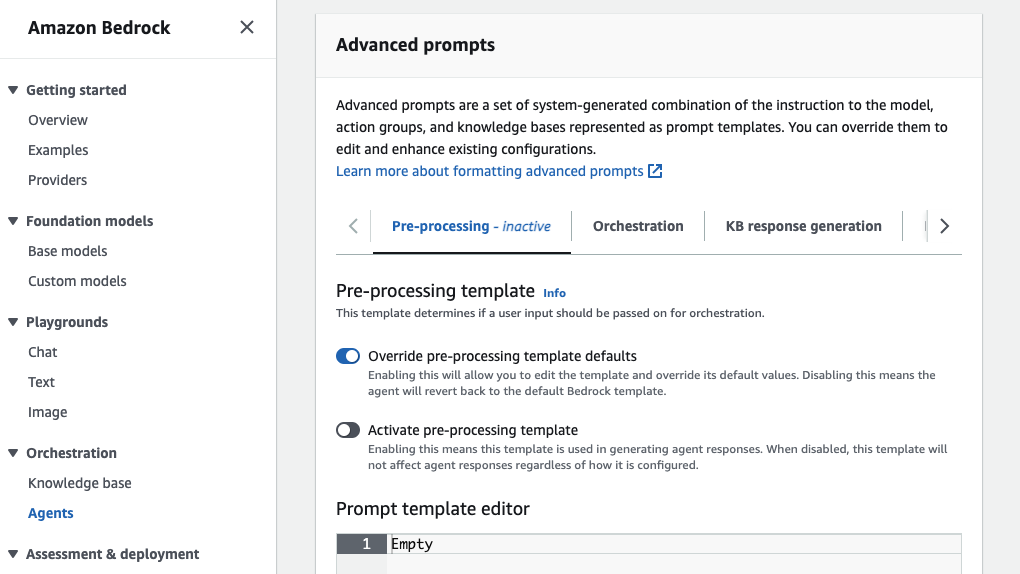

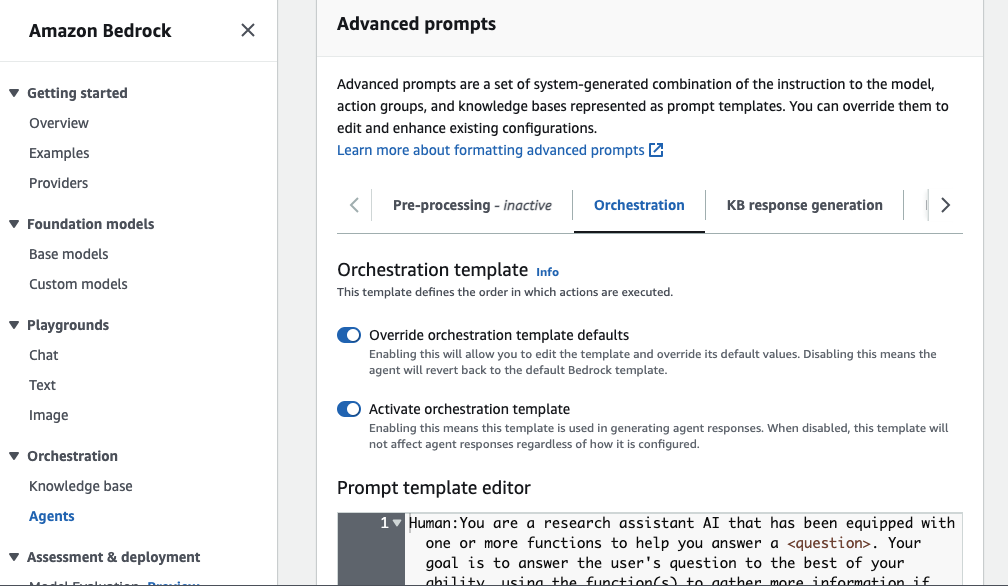

In [16]:
# Add a resource-based policy for Lambda function to give a permission for Bedrock agent accessing Lambda 

statement_id = 'allow-bedrock-agent'
response = lambda_client.add_permission(
    FunctionName=function_name,
    StatementId=statement_id,
    Action='lambda:InvokeFunction',
    Principal='bedrock.amazonaws.com', 
    SourceArn=agent_arn
)

In [17]:
# Add action group to Bedrock Agent

response = bedrock_agent_client.create_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupName='image-creator-action',
    actionGroupExecutor={
        'lambda': lambda_arn
    },
    apiSchema={
        's3': {
            's3BucketName': bucket_name,
            's3ObjectKey': 'ActionSchema/ActionSchema.json'
        },
    },
    actionGroupState='ENABLED'
)

> Edit Agent to enable "User Input" of Agent to "Yes" as below example (I didn't find the parameter of sdk to achieve this)

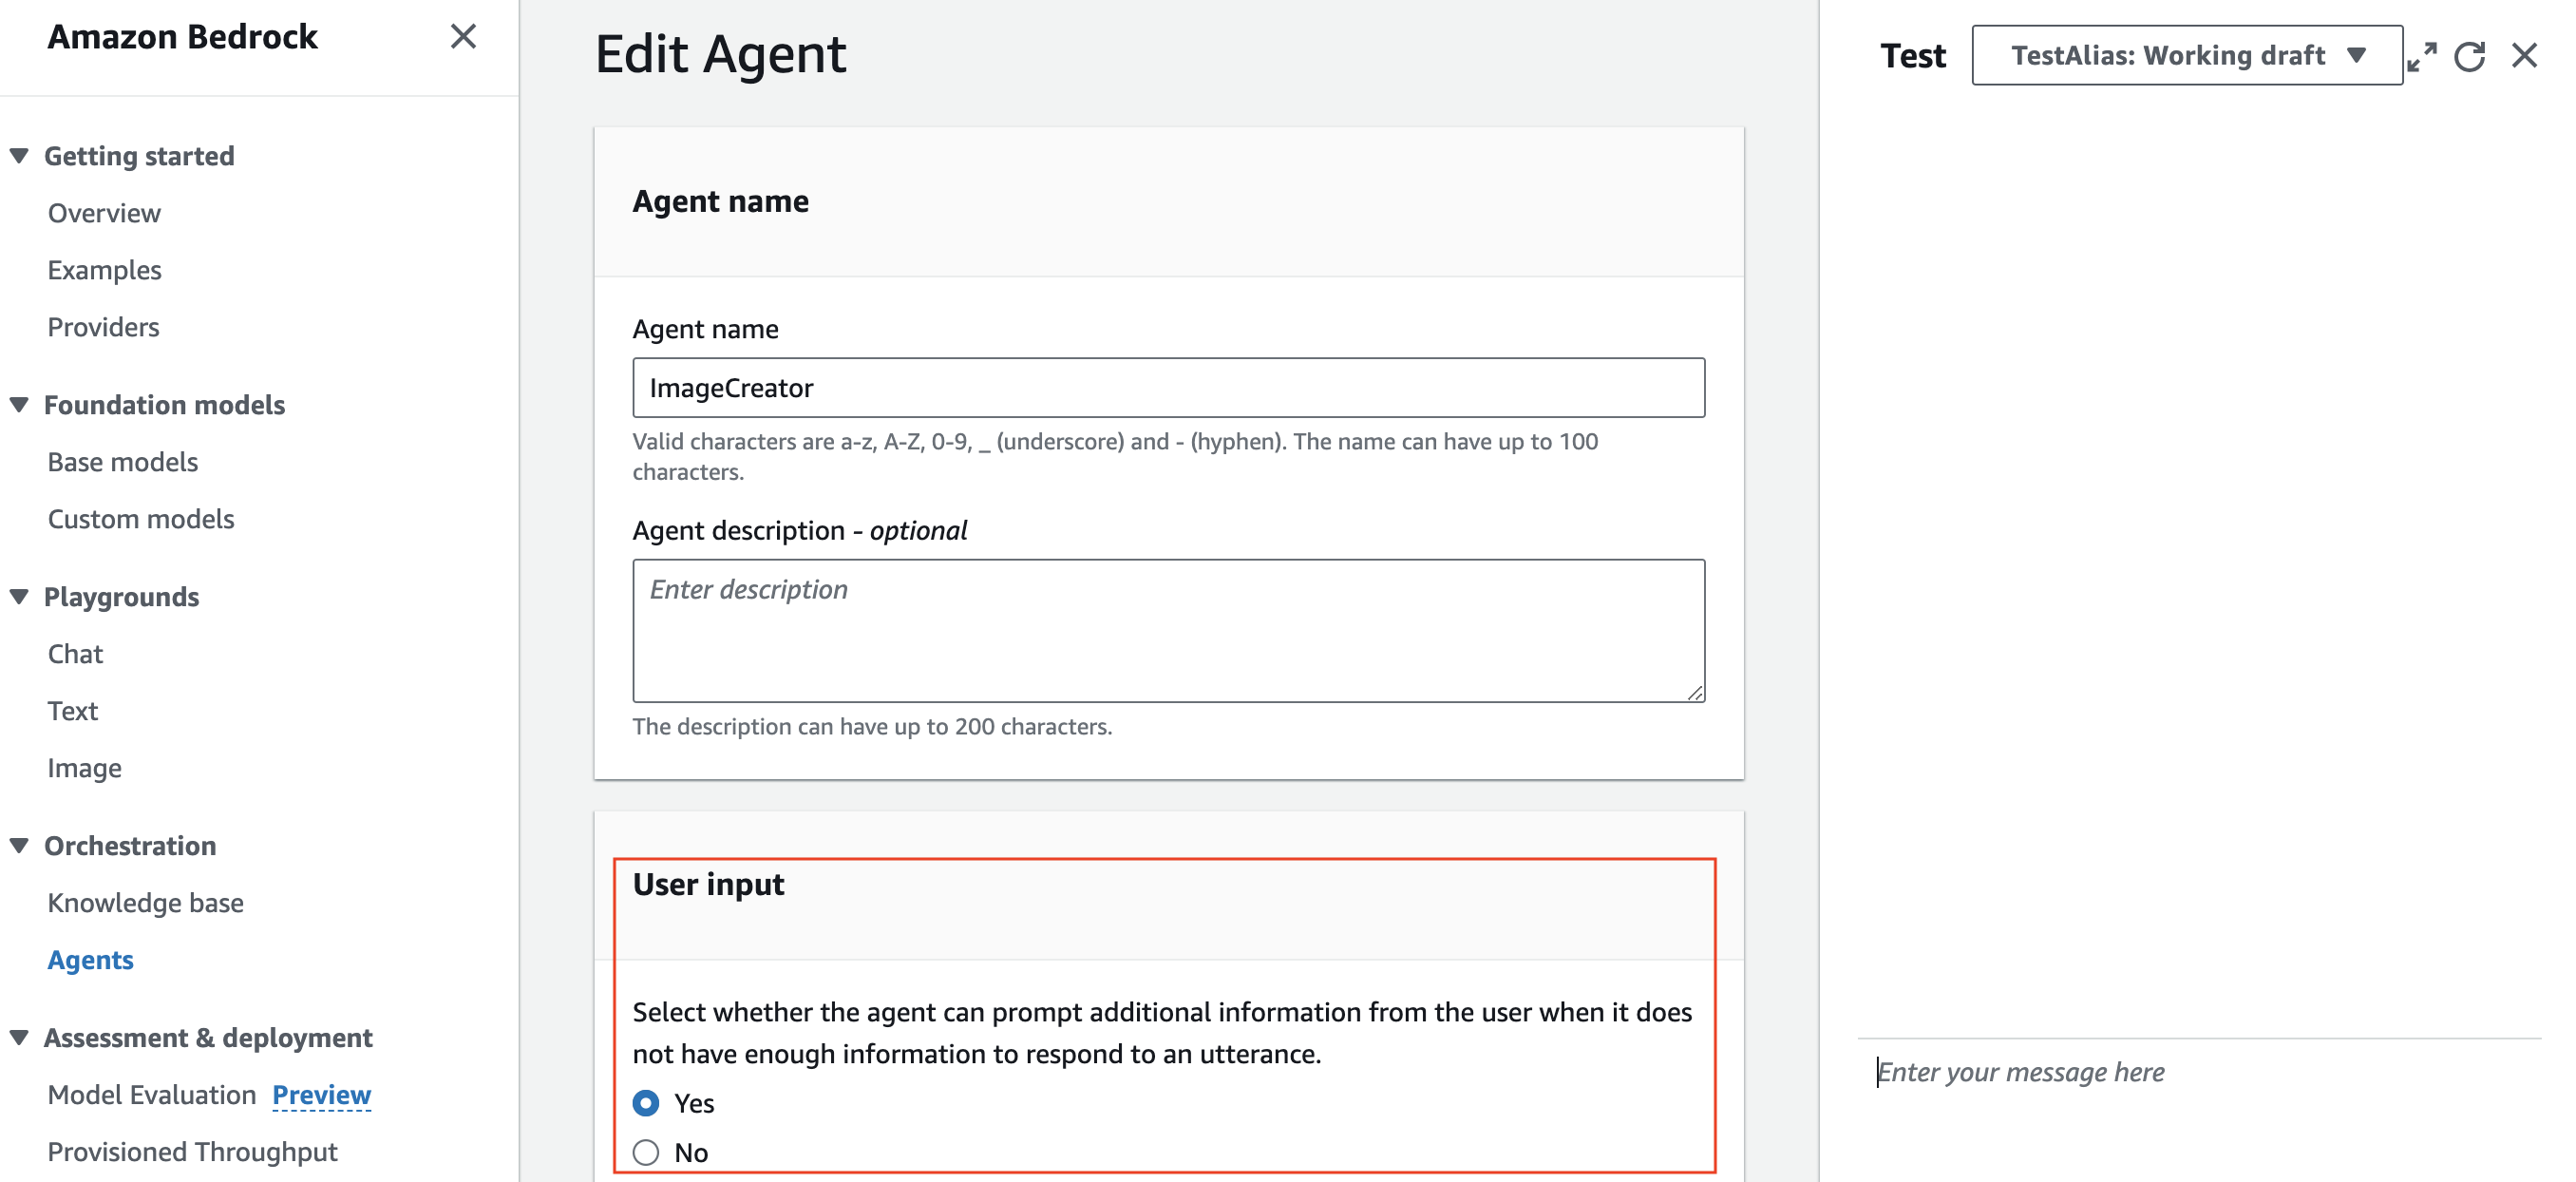

In [18]:
# Prepare the Bedrock Agent for testing

response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)

### 6. Bedrock Agent test

Now you can switch to Bedrock Agent console to test Agent as below:

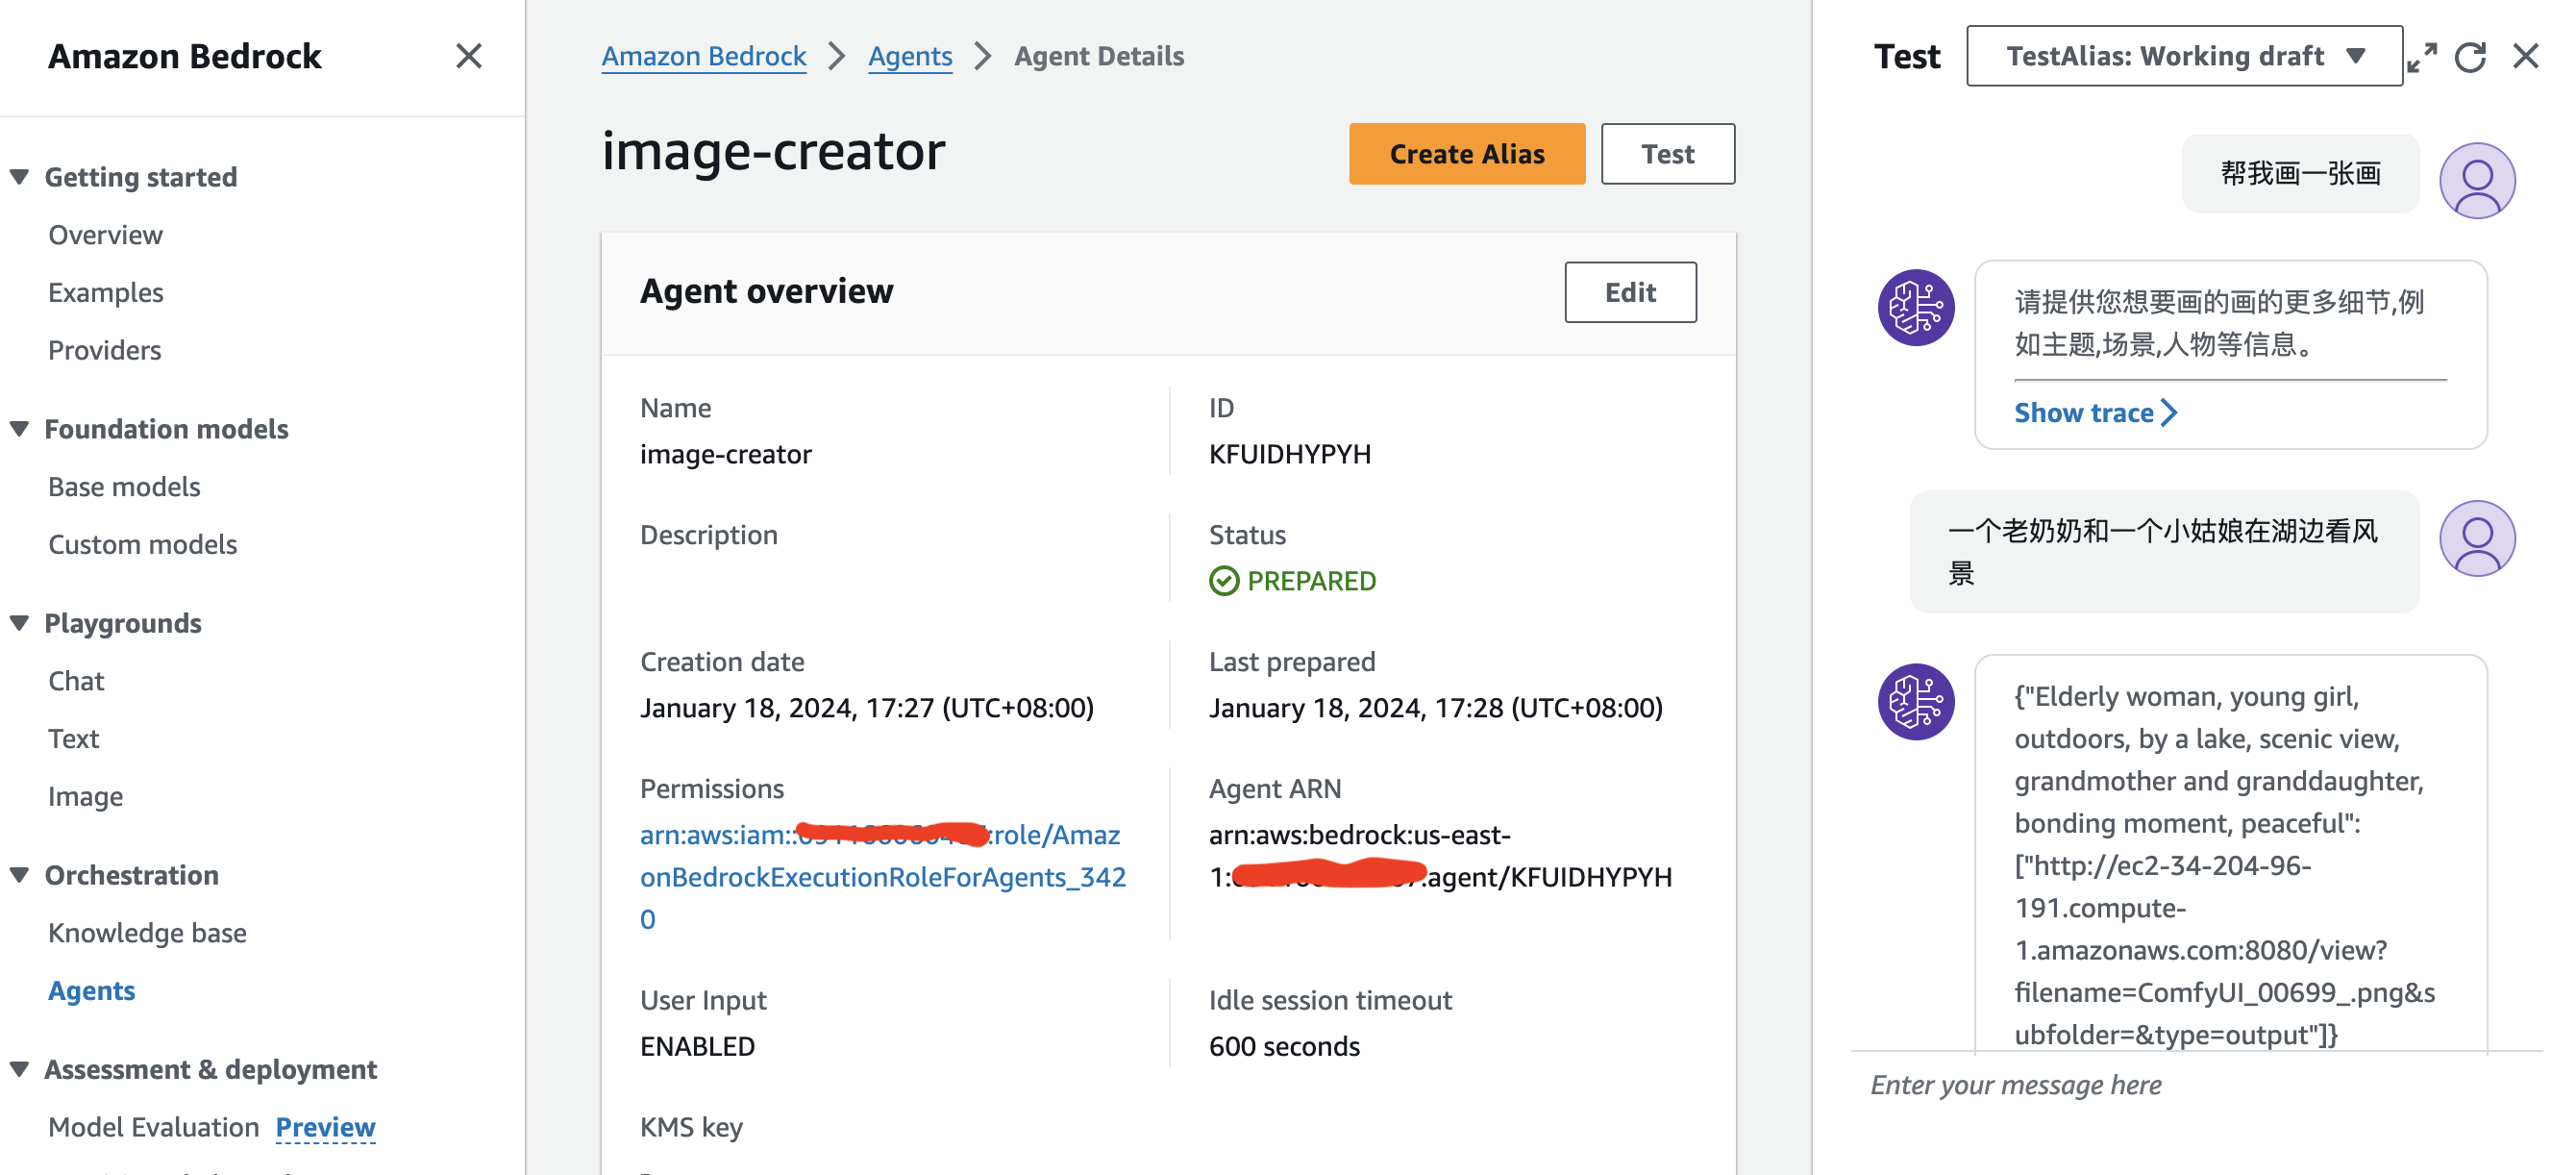

### 7. Create alias of Bedrock Agent and create corresponding images 

In [19]:
# Create alias and get a valid alias id

response = bedrock_agent_client.create_agent_alias(
    agentId=agent_id,
    agentAliasName='ImageCreator',
)
alias_id = response['agentAlias']['agentAliasId']

In [20]:
# Create a folder to prepare saving created images

images_folder = "./output_image"
os.makedirs(images_folder, exist_ok=True)

In [21]:
bedrock_agent_runtime_client = boto3_session.client('bedrock-agent-runtime')

agent_alias_id = alias_id
session_id = str(uuid.uuid1())

def create_image(input_text):
    response = bedrock_agent_runtime_client.invoke_agent(inputText=input_text,
        agentId=agent_id,
        agentAliasId=agent_alias_id,
        sessionId=session_id,
    )
    event_stream = response['completion']
    for event in event_stream:
        if 'chunk' in event:
            output_data = event['chunk']['bytes'].decode('utf8')
    return output_data

In [22]:
input_text = "A great mountain with snow on it" # You can use any language for your prompt
output_data = create_image(input_text)
print(output_data)

{"Majestic mountain peak, snow covered, tall, jagged rocks, icy conditions, aerial view, wintry landscape, clouds in sky":["http://ec2-34-204-96-191.compute-1.amazonaws.com:8080/view?filename=ComfyUI_01014_.png&subfolder=&type=output"]}


Image Prompt: Majestic mountain peak, snow covered, tall, jagged rocks, icy conditions, aerial view, wintry landscape, clouds in sky
Image 'ComfyUI_01014_.png' saved to './output_image'


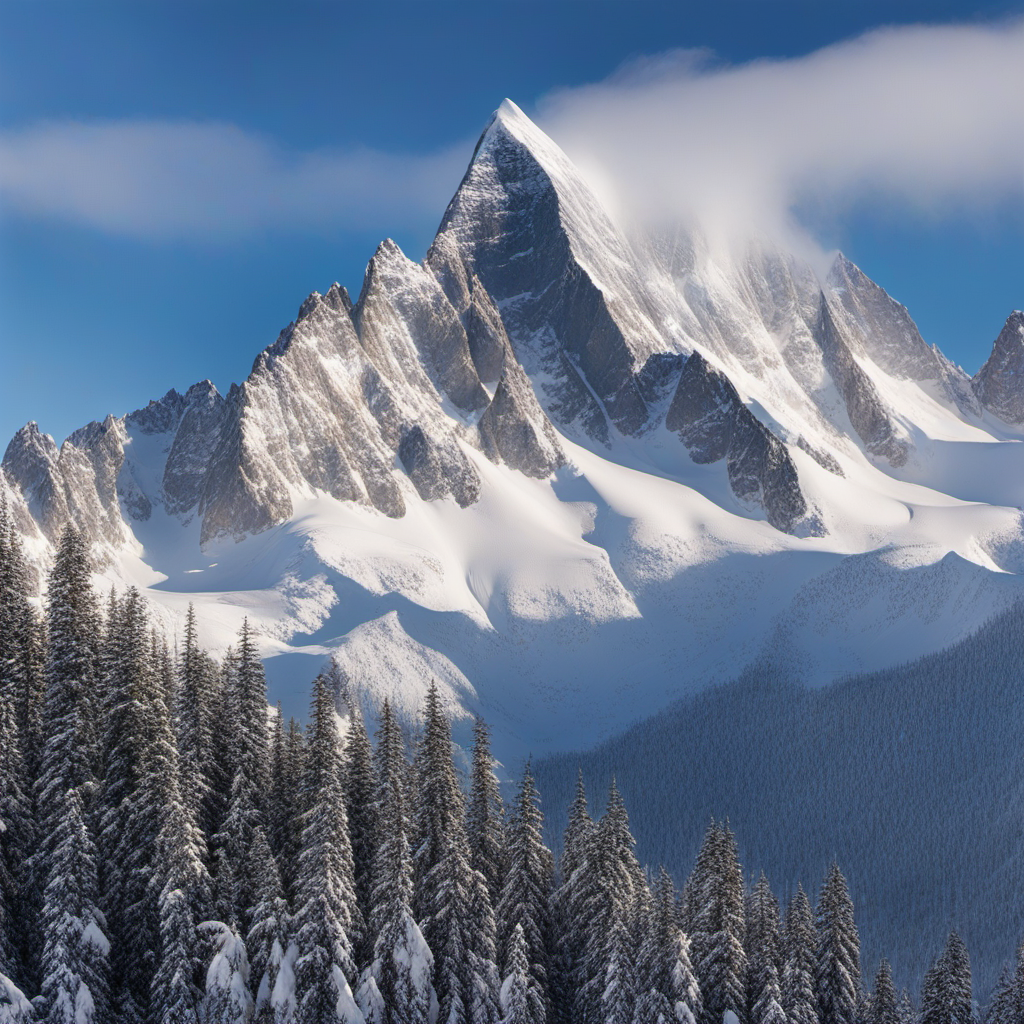

In [23]:
output_data = json.loads(output_data)
for key, value in output_data.items():
    print("Image Prompt:", key)
    for image_url in value:
        image_name = image_url.split("filename=")[1].split("&")[0]
        # Send Http request and save image
        response = requests.get(image_url)
        if response.status_code == 200:
            save_path = os.path.join(images_folder, image_name)
            with open(save_path, "wb") as file:
                file.write(response.content)
                print(f"Image '{image_name}' saved to '{images_folder}'")
        else:
            print("Cannot download iamge")
        display(Image(filename=save_path))

In [24]:
input_text = "长河落日圆" # You can use any language for your prompt, e.g. I use Chinese here
output_data = create_image(input_text)
print(output_data)

{"Riverbank landscape, long winding river, orange sunset, circular sun lowering over horizon, reflections on water, peaceful evening scene":["http://ec2-34-204-96-191.compute-1.amazonaws.com:8080/view?filename=ComfyUI_01015_.png&subfolder=&type=output"]}


Image Prompt: Riverbank landscape, long winding river, orange sunset, circular sun lowering over horizon, reflections on water, peaceful evening scene
Image 'ComfyUI_01015_.png' saved to './output_image'


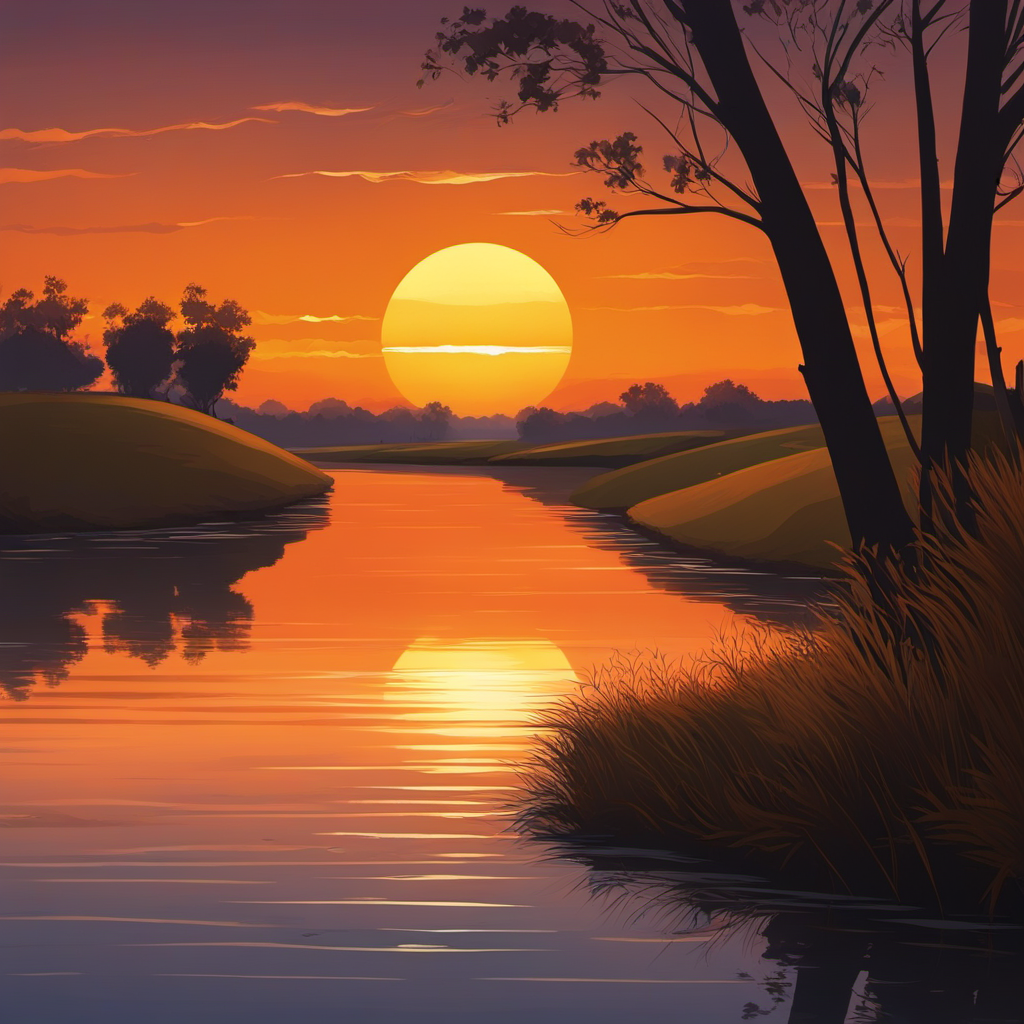

In [25]:
output_data = json.loads(output_data)
for key, value in output_data.items():
    print("Image Prompt:", key)
    for image_url in value:
        image_name = image_url.split("filename=")[1].split("&")[0]
        # Send Http request and save image
        response = requests.get(image_url)
        if response.status_code == 200:
            save_path = os.path.join(images_folder, image_name)
            with open(save_path, "wb") as file:
                file.write(response.content)
                print(f"Image '{image_name}' saved to '{images_folder}'")
        else:
            print("Cannot download iamge")
        display(Image(filename=save_path))

### 8. Build frontend APP by Streamlit

#### 8.1 Store "agent_id", "agent_alias_id", "lambda function_name" as local json file for Streamlit

In [26]:
# Store file in local directory, e.g. /tmp

parameters = {
    "agent_id": agent_id,
    "agent_alias_id": agent_alias_id,
    "function_name": function_name
}
json_parameters = json.dumps(parameters)
with open('/tmp/parameter.json', 'w') as file:
    file.write(json_parameters)

#### 8.2 Switch to Sagemaker notebook terminal to run Streamlit App

* Download “requirements.txt” and “streamlit_chatbot.py” and run below commands


 $ cd SageMaker/  

 $ pip install -r requirements.txt  
 
 $ mkdir -p .streamlit/
 
 $ echo -e "[server]\nheadless = true\nenableXsrfProtection=false\nenableCORS = false" > .streamlit/config.tom
 
 $ streamlit run streamlit_imageCreator.py --server.port 6010  


* Open a browser and type dowm below address to access Stream App

https://\<Notebook Domain ID\>.notebook.\<region\>.sagemaker.aws/proxy/6010/  

As below screenshoot:

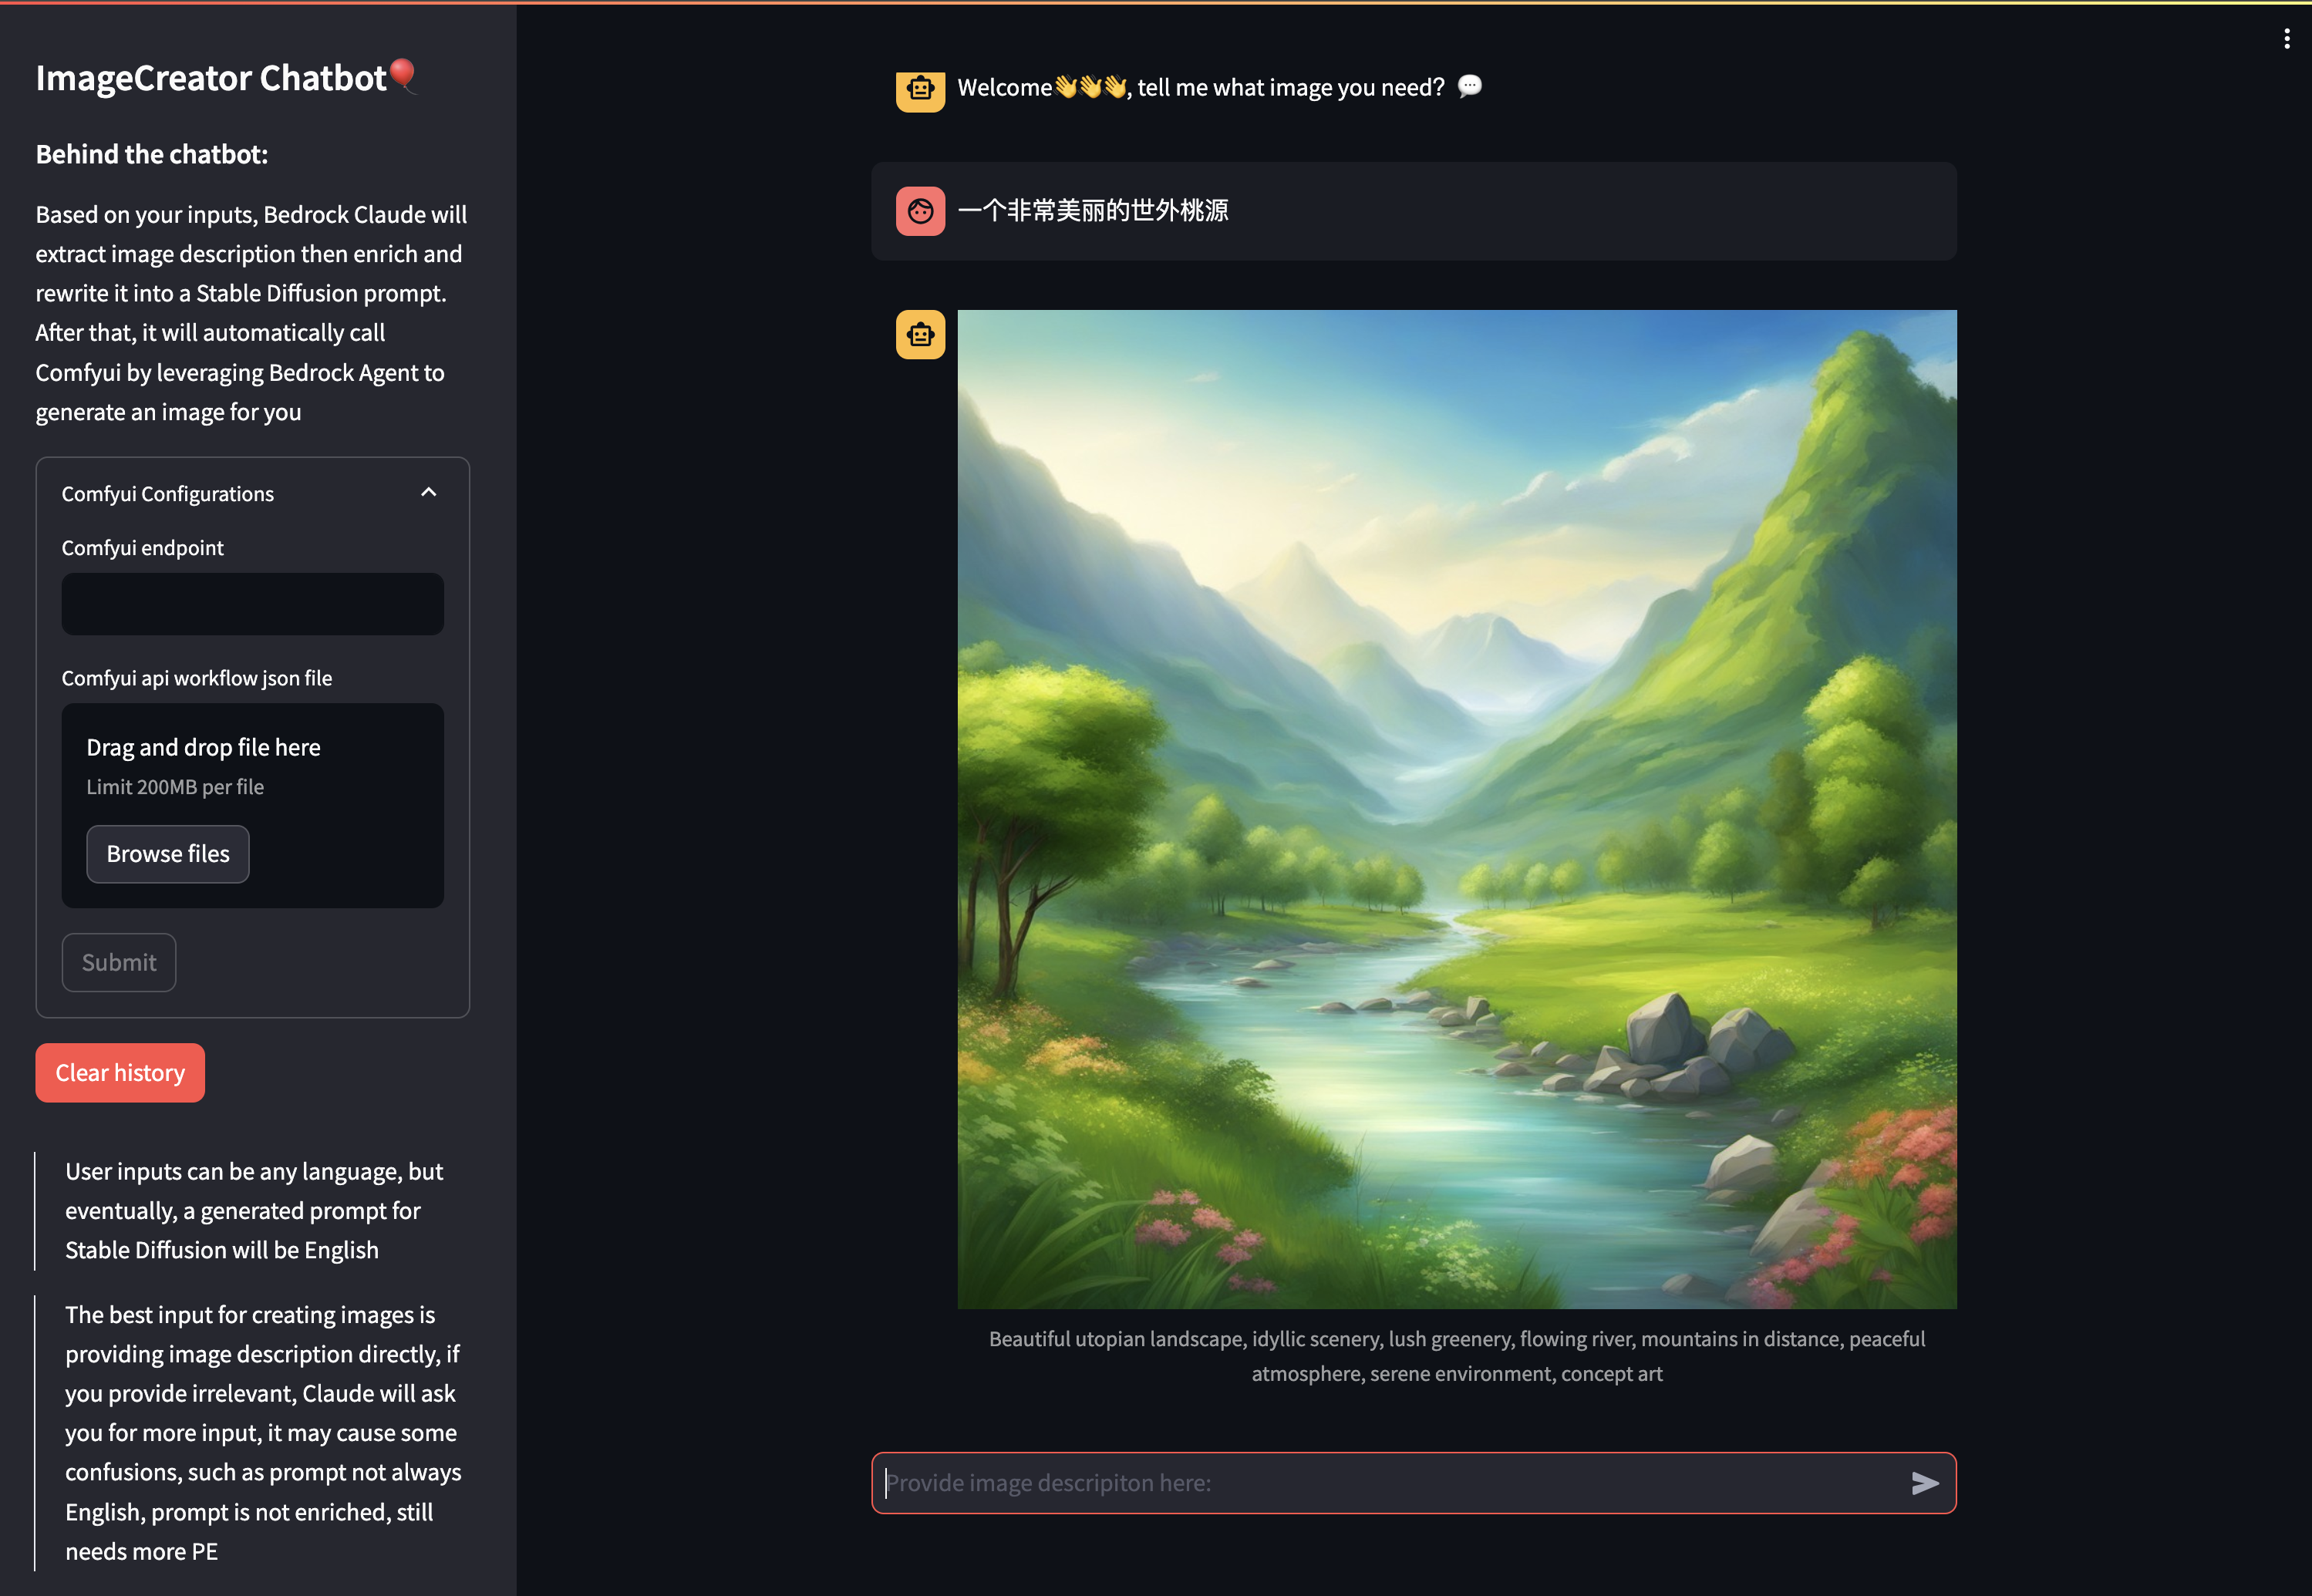